# Dfs2

**This material have been updated to use MIKE IO 1.0, which currently avilable in a [beta version](https://pypi.org/project/mikeio/1.0b2/)**

[DFS - Reference manual](https://docs.mikepoweredbydhi.com/core_libraries/dfs/dfs-file-system/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mikeio

## Reading data

In [2]:
ds = mikeio.read("data/gebco_sound.dfs2")
ds

<mikeio.Dataset>
dims: (time:1, y:264, x:216)
time: 2020-05-15 11:04:52 (time-invariant)
geometry: Grid2D (ny=264, nx=216)
items:
  0:  Elevation <Total Water Depth> (meter)

In [3]:
type(ds)

mikeio.dataset.Dataset

In [4]:
ds.shape

(1, 264, 216)

In [5]:
elevation = ds['Elevation']
type(elevation)

mikeio.dataarray.DataArray

In [6]:
elevation.shape

(1, 264, 216)

<AxesSubplot:xlabel='Longitude [degrees]', ylabel='Latitude [degrees]'>

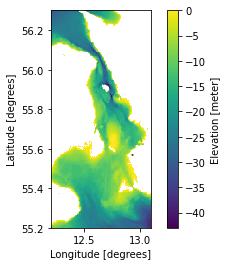

In [7]:
elevation.plot()

## Spatial axes

In [8]:
ds.geometry

<mikeio.Grid2D>
x: [12.2, 12.21, ..., 13.1] (nx=216, dx=0.004167)
y: [55.2, 55.21, ..., 56.3] (ny=264, dy=0.004167)
projection: LONG/LAT

## Extract data at location

In [9]:
stn = 12.74792, 55.865
da_stn = elevation.interp(x=stn[0], y=stn[1])
da_stn

<mikeio.DataArray>
name: Elevation
dims: (time:1)
time: 2020-05-15 11:04:52 (time-invariant)
geometry: GeometryPoint2D(x=12.74792, y=55.865)
values: [-42.69764539]

In [10]:
da_stn.values

array([-42.69764539])

Text(12.3, 55.8, 'Denmark')

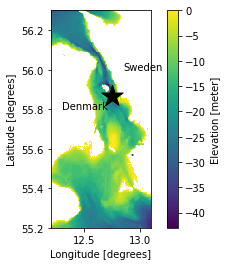

In [11]:
elevation.plot()
plt.scatter(stn[0],stn[1],marker='*',s=500,c='black')
plt.text(12.85, 56.0, "Sweden")
plt.text(12.3, 55.8, "Denmark")

## Slicing

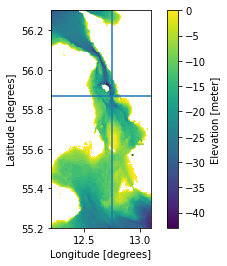

In [12]:
elevation.plot()
plt.axvline(stn[0])
plt.axhline(stn[1])

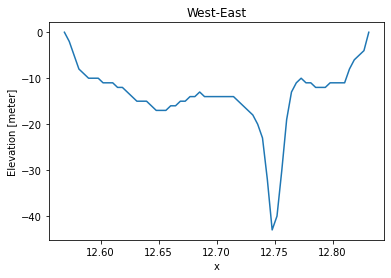

In [13]:
elevation.sel(y=stn[1]).plot(title="West-East");

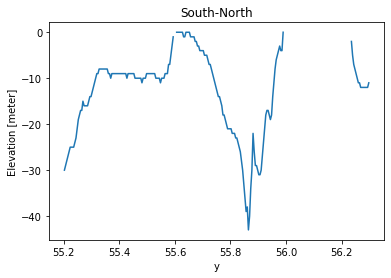

In [14]:
elevation.sel(x=stn[0]).plot(title="South-North");

## Writing data

### Geographical coordinates

In [15]:
data_i = np.arange(24).reshape(2,4,3)
data_i.shape

(2, 4, 3)

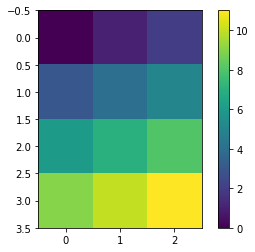

In [16]:
plt.imshow(data_i[0]) # first timestep
plt.colorbar()

In [17]:
grid = mikeio.Grid2D(x0 = 12.0, dx= 1.0, y0= 55.0, dy=1.0, nx=3, ny=4, projection="LONG/LAT")
grid

<mikeio.Grid2D>
x: [12, 13, 14] (nx=3, dx=1)
y: [55, 56, ..., 58] (ny=4, dy=1)
projection: LONG/LAT

In [18]:
import pandas as pd

nt = data_i.shape[0]

da = mikeio.DataArray(data = data_i,
                      geometry=grid,
                      time = pd.date_range("2020",periods=nt,freq='D'),
                      item= mikeio.ItemInfo("Example", mikeio.EUMType.Elevation))

da

<mikeio.DataArray>
name: Example
dims: (time:2, y:4, x:3)
time: 2020-01-01 00:00:00 - 2020-01-02 00:00:00 (2 records)
geometry: Grid2D (ny=4, nx=3)

In [19]:
ds = mikeio.Dataset([da])
ds

<mikeio.Dataset>
dims: (time:2, y:4, x:3)
time: 2020-01-01 00:00:00 - 2020-01-02 00:00:00 (2 records)
geometry: Grid2D (ny=4, nx=3)
items:
  0:  Example <Elevation> (meter)

In [20]:
ds.to_dfs("example_geo.dfs2")

Screenshot from MIKE Zero (viridis palette).

:::{note}
Note the location of the origin.
:::


![](images/example_dfs2_geo.png)

### Projected coordinates


Projection string in WKT format. Use MIKE Zero for formatting. Some shorthands are available for UTM zones, e.g. UTM-32.

In [21]:
pgrid = mikeio.Grid2D(x0 = 337100.0, dx= 10000.0, y0= 6122900.0, dy=10000.0, nx=3, ny=4, projection="UTM-32")
pgrid

<mikeio.Grid2D>
x: [3.371e+05, 3.471e+05, 3.571e+05] (nx=3, dx=1e+04)
y: [6.123e+06, 6.133e+06, ..., 6.153e+06] (ny=4, dy=1e+04)
projection: UTM-32

In [22]:
pda = mikeio.DataArray(data = data_i,
                       geometry=pgrid,
                       time = pd.date_range("2020",periods=nt,freq='D'),
                       item= mikeio.ItemInfo("Example", mikeio.EUMType.Elevation))

pda

<mikeio.DataArray>
name: Example
dims: (time:2, y:4, x:3)
time: 2020-01-01 00:00:00 - 2020-01-02 00:00:00 (2 records)
geometry: Grid2D (ny=4, nx=3)

<AxesSubplot:xlabel='Easting [m]', ylabel='Northing [m]'>

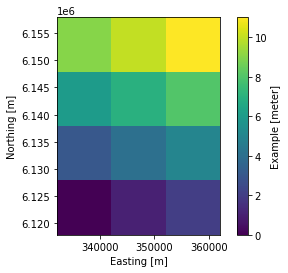

In [23]:
pda.plot()

In [24]:
pda.to_dfs("example_proj.dfs2")

Screenshot from MIKE Zero using a projected coordinate system.

![](images/example_dfs2_proj.png)